In [2]:
# imports and settings
from pandas import DataFrame

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

# set the default theme for Seaborn plots
sns.set_theme()
sns.set(rc={'figure.figsize':(5,5)})

# Logistic Regression with Pytorch

Our goals for this lesson:

* Introduce the sigmoid activation function for converting linear outputs into probabilities
* Practice building PyTorch Datasets and Dataloaders
* Gain some intuition for the binary cross entropy loss function which is used in binary classification problems
* Practice using the nn.module class to construct a neural network
* Practice putting it altogether to fit our model and visualize the results
* Discuss splitting data in training and validation sets

**Logistic Regression:** A logistic regression binary classification model takes an input feature vector, x, and returns the probability that feature vector belongs to one of two classes that are labeled 0 and 1.  It does this by taking a biased and weighted combination of the input vector and passing it through a sigmoid activation function to give the probability that the input vector has label 1.

You can visualize this idea as trying to choose the best line in the plane to separate the blue and orange points in the figure below:

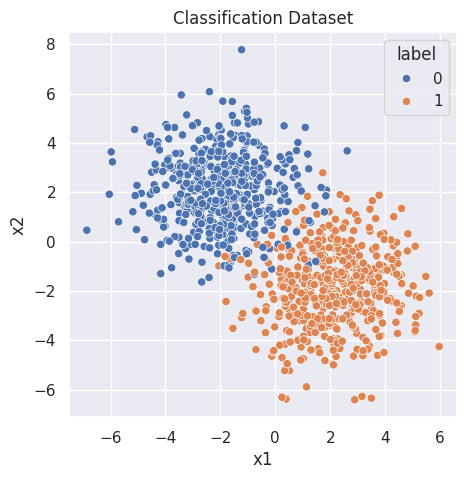

In [3]:
# generate 2d classification dataset
ctrs = [[-2,2],[2,-2]]
std = 1.5
X, y = make_blobs(n_samples=1000, centers=ctrs,
                  cluster_std = std, n_features=2,
                  random_state = 42)

# scatter plot, dots colored by class value
df = DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))
sns.scatterplot( x = 'x1', y = 'x2', data = df,
                hue = 'label').set(title='Classification Dataset');


## Splitting Data in Training and Validation Sets

We want our models to be able to make predictions on new input data that wasn't seen in training. Therefore we shouldn't assess the quality of the model on the training data.  Instead we'll split the dataset into a training set and a validation set.  The the training set is used to optimize the model parameters and the validation set is used to assess the quality of the model fit.  An 80%/20% split it commonly used, but it can also vary.

The Scikit-Learn package `sklearn` has a helpful command called `train_test_split` that makes splitting a dataset simple.  In the code cell below we randomly select 80% of the data for training and 20% for the validation set.  

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2,
                                                      random_state=42)

We can visualize the split data:

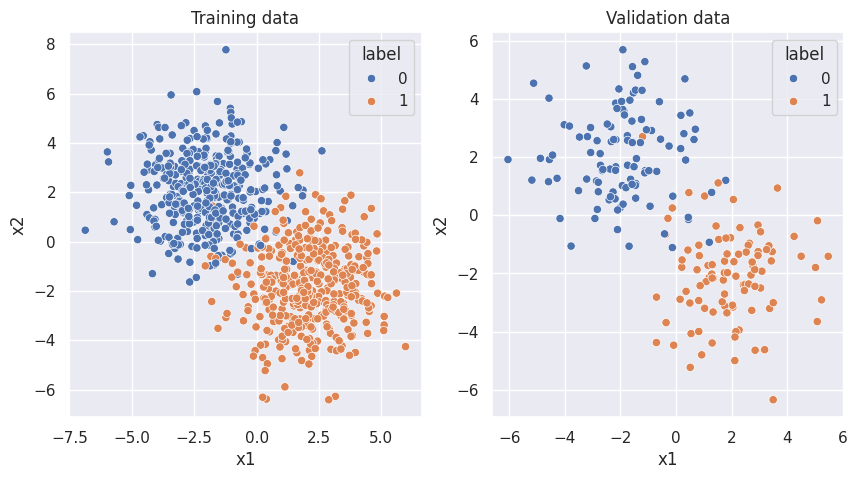

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

df_train = DataFrame(dict(x1=X_train[:,0], x2=X_train[:,1], label=y_train))
df_valid = DataFrame(dict(x1=X_valid[:,0], x2=X_valid[:,1], label=y_valid))

axes[0].set_title('Training data')
axes[1].set_title('Validation data')

sns.scatterplot( ax = axes[0], x = 'x1', y = 'x2', data = df_train, hue = 'label');
sns.scatterplot( ax = axes[1], x = 'x1', y = 'x2', data = df_valid, hue = 'label');

## Datasets and Dataloaders

First we'll convert our data into Pytorch tensors.

In [6]:
# convert the numpy arrays from sklearn to tensors
X_train = torch.Tensor(X_train)
X_valid = torch.Tensor(X_valid)
y_train = torch.Tensor(y_train)
y_valid = torch.Tensor(y_valid)
# cast the inputs to torch.float
# the targets are integers, but the BCELoss funciton expects floats
X_train = torch.as_tensor(X_train, dtype = torch.float)
X_valid = torch.as_tensor(X_valid, dtype = torch.float)
y_train = torch.as_tensor(y_train, dtype = torch.float)
y_valid = torch.as_tensor(y_train, dtype = torch.float)

In [7]:
class RegressionData(Dataset):
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, X, y):
        # X is a 2D tensor with num_obs x 2
        # y is a 1D tensor with num_obs
        # but we want it to be num_obs x 1 (an array of 1D outputs)
        # can use unsqueeze to add the single dimension at the end
        self.X = X
        self.y = y.unsqueeze(-1)

    def __len__(self):
        return(len(self.X))

    def __getitem__(self, idx):
        return(self.X[idx], self.y[idx])

# instantiate Dataset object for current training data
dset_train = RegressionData(X_train, y_train)
dset_valid = RegressionData(X_valid, y_valid)

We will create the dataloaders just before the training loop further below, but we'll instantiate one here so we can see a small batch to see that it works correctly.

In [8]:
# instantiate DataLoader
train_dataloader = DataLoader(dset_train, batch_size=4 , shuffle=True)
inputs, targets = next(iter(train_dataloader))
print(inputs)
print(inputs.shape)
print(targets)
print(targets.shape)

tensor([[-3.9205,  3.3087],
        [ 1.4177, -1.7444],
        [-2.3314,  2.0403],
        [-1.5138,  1.8048]])
torch.Size([4, 2])
tensor([[0.],
        [1.],
        [0.],
        [0.]])
torch.Size([4, 1])


In [9]:
##################################################
##
##
##################################################

class LogisticRegression(nn.Module):
    '''
    Logistic Regression: 1 hidden layer with a single neuron
    and a sigmoid activation function
    '''
    def __init__(self, nInput):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(nInput, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return(self.layers(x))

nInput = 2
model = LogisticRegression(nInput)

In [21]:
##################################################
## training the model
##################################################

epochs = 200
outputInterval = 10
learningRate = 0.1
batchSize = 100
nInput = 2

# Create a new instance of the model to randomize the weights each time
torch.manual_seed(41)
model = LogisticRegression(nInput)

# Make new instance of dataloader with batchSize
train_dataloader = DataLoader(dset_train, batch_size=batchSize, shuffle=True)
valid_dataloader = DataLoader(dset_valid, batch_size=batchSize, shuffle=False)

# Define the loss function and optimizer
loss_function = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

# Run the training loop
for epoch in range(epochs):

    # Training Phase
    model.train()
    loss_train = 0.0
    correct_train = 0

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        loss_train += loss.item()

        # compute accuracy metric
        prediction = torch.round(outputs.detach())
        correct_train += (prediction == targets).sum()
    accuracy_train = 100 * correct_train.item() / len(train_dataloader.dataset)

    # Validation phase
    model.eval()
    loss_valid = 0.0
    correct_valid = 0

    with torch.no_grad():
        for inputs, targets in valid_dataloader:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)
            loss_valid += loss.item()

            # compute accuracy metric
            prediction = torch.round(outputs)
            correct_valid += (prediction == targets).sum()
        accuracy_valid = 100 * correct_valid.item() / len(valid_dataloader.dataset)

    # Calculate average losses
    loss_train = loss_train / len(train_dataloader.dataset)
    loss_valid = loss_valid / len(valid_dataloader.dataset)

    if (epoch + 1) % outputInterval == 0:
        print( (f'At epoch {epoch+1} '
                f'train_loss = {loss_train:.3e}, '
                f'val_loss = {loss_valid:.3e}, '
                f'accuracy_train = {accuracy_train:.2f}% '
                f'accuracy_valid = {accuracy_valid:.2f}%' ) )


At epoch 10 train_loss = 9.253e-04, val_loss = 2.119e-02, accuracy_train = 97.12% accuracy_valid = 50.50%
At epoch 20 train_loss = 7.895e-04, val_loss = 2.525e-02, accuracy_train = 97.38% accuracy_valid = 50.50%
At epoch 30 train_loss = 7.438e-04, val_loss = 2.775e-02, accuracy_train = 97.25% accuracy_valid = 51.00%
At epoch 40 train_loss = 7.212e-04, val_loss = 2.954e-02, accuracy_train = 97.25% accuracy_valid = 51.00%
At epoch 50 train_loss = 7.080e-04, val_loss = 3.090e-02, accuracy_train = 97.25% accuracy_valid = 51.00%
At epoch 60 train_loss = 6.996e-04, val_loss = 3.201e-02, accuracy_train = 97.25% accuracy_valid = 51.00%
At epoch 70 train_loss = 6.940e-04, val_loss = 3.289e-02, accuracy_train = 97.25% accuracy_valid = 51.00%
At epoch 80 train_loss = 6.900e-04, val_loss = 3.784e-02, accuracy_train = 97.25% accuracy_valid = 51.00%
At epoch 90 train_loss = 6.872e-04, val_loss = 3.848e-02, accuracy_train = 97.25% accuracy_valid = 51.00%
At epoch 100 train_loss = 6.851e-04, val_loss 

In [18]:
outputs[:10], targets[:10]

(tensor([[5.8224e-04],
         [1.6842e-03],
         [2.6707e-04],
         [3.2527e-04],
         [9.9999e-01],
         [2.0721e-04],
         [9.7581e-01],
         [6.7009e-01],
         [9.9850e-01],
         [9.9782e-01]]),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.],
         [1.],
         [0.],
         [0.]]))

In [23]:
for p in model.parameters():
    print(p.detach().numpy().round(4))

[[ 1.8951 -1.9348]]
[0.2554]


In [8]:


epochs = 10000
learning_rate = 0.01
criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


losses = []
losses_test = []
Iterations = []

for epoch in range(1,epochs+1):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]

    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves

    optimizer.step() # Updates weights and biases with the optimizer (SGD)


    if epoch % 1000==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test)

            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())

            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)

            print(f"Epoch: {epoch}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")



Epoch: 1000. 
Test - Loss: 0.14521907269954681. Accuracy: 98.78787878787878
Train -  Loss: 0.1415265053510666. Accuracy: 99.55223880597015

Epoch: 2000. 
Test - Loss: 0.08918923139572144. Accuracy: 99.0909090909091
Train -  Loss: 0.08538269251585007. Accuracy: 99.70149253731343

Epoch: 3000. 
Test - Loss: 0.06734538078308105. Accuracy: 99.39393939393939
Train -  Loss: 0.06353098899126053. Accuracy: 99.70149253731343

Epoch: 4000. 
Test - Loss: 0.05540908873081207. Accuracy: 99.39393939393939
Train -  Loss: 0.05161362886428833. Accuracy: 99.70149253731343

Epoch: 5000. 
Test - Loss: 0.04776427894830704. Accuracy: 99.39393939393939
Train -  Loss: 0.043997108936309814. Accuracy: 99.70149253731343

Epoch: 6000. 
Test - Loss: 0.04239150136709213. Accuracy: 99.39393939393939
Train -  Loss: 0.03865613788366318. Accuracy: 99.85074626865672

Epoch: 7000. 
Test - Loss: 0.038377802819013596. Accuracy: 99.39393939393939
Train -  Loss: 0.034675367176532745. Accuracy: 99.85074626865672

Epoch: 8000.

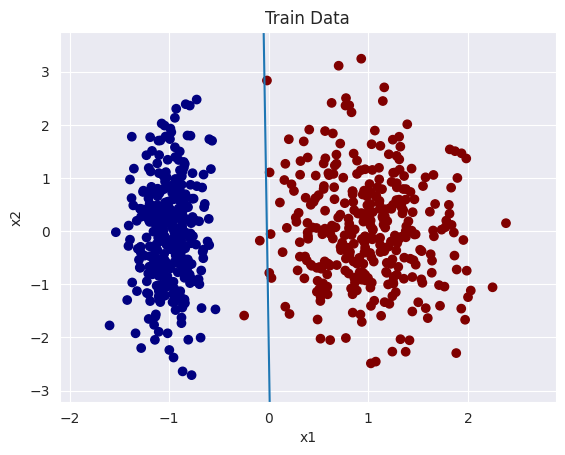

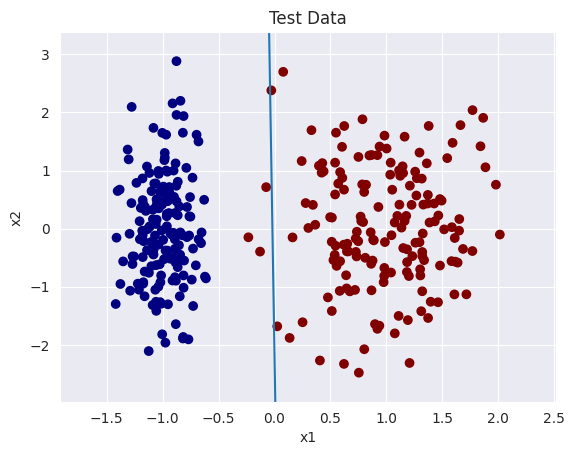

In [10]:
def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().numpy()

    w = parm['linear.weight'][0]
    b = parm['linear.bias'][0]
    plt.scatter(X[:, 0], X[:, 1], c=y,cmap='jet')
    u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
    plt.plot(u, (0.5-b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()


# Train Data
model_plot(model,X_train,y_train,'Train Data')

# Test Dataset Results
model_plot(model,X_test,y_test,'Test Data')

In [3]:
model

LogisticRegression(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)

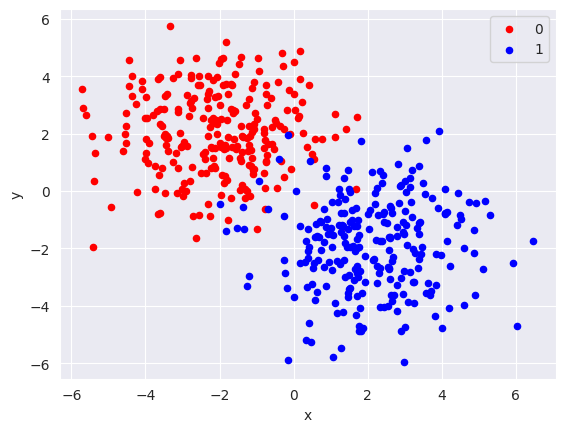

In [20]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from pandas import DataFrame
# generate 2d classification dataset
ctrs = [[-2,2],[2,-2]]
std = 1.5
X, y = make_blobs(n_samples=500, centers=ctrs, cluster_std = std, n_features=2)
# scatter plot, dots colored by class value
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = plt.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
plt.show()

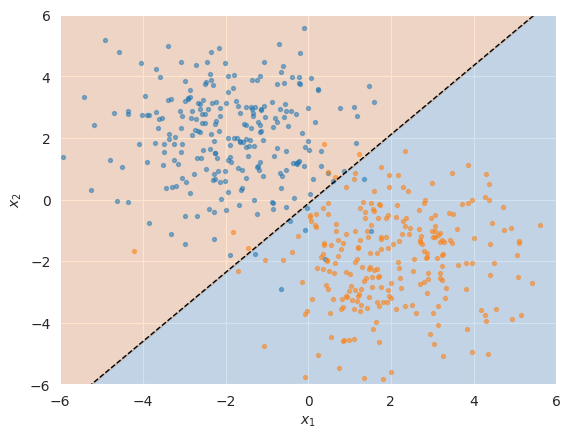

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model

ctrs = [[-2,2],[2,-2]]
std = 1.5
X, y = make_blobs(n_samples=500, centers=ctrs, cluster_std = std, n_features=2)


# Fit the data to a logistic regression model.
clf = sklearn.linear_model.LogisticRegression()
clf.fit(X, y)

# Retrieve the model parameters.
b = clf.intercept_[0]
w1, w2 = clf.coef_.T
# Calculate the intercept and gradient of the decision boundary.
c = -b/w2
m = -w1/w2

# Plot the data and the classification with the decision boundary.
xmin, xmax = -6, 6
ymin, ymax = -6, 6
xd = np.array([xmin, xmax])
yd = m*xd + c
plt.plot(xd, yd, 'k', lw=1, ls='--')
plt.fill_between(xd, yd, ymin, color='tab:blue', alpha=0.2)
plt.fill_between(xd, yd, ymax, color='tab:orange', alpha=0.2)

plt.scatter(*X[y==0].T, s=8, alpha=0.5)
plt.scatter(*X[y==1].T, s=8, alpha=0.5)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.ylabel(r'$x_2$')
plt.xlabel(r'$x_1$')

plt.show()